In [4]:
%load_ext autoreload
%autoreload 2

import time
import os
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from skimage.io import imread

from sklearn import datasets
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import SparseCoder, DictionaryLearning

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
img = imread('/home/yuncong/CSHL_data_processed/MD593_lossless_aligned_cropped_grayscale/MD593_0130_lossless_aligned_cropped_grayscale.tif')

In [8]:
patch_size = (50, 50)

data = extract_patches_2d(img[:10000, :10000], patch_size, max_patches=10000)
data = np.reshape(data, (len(data), -1))

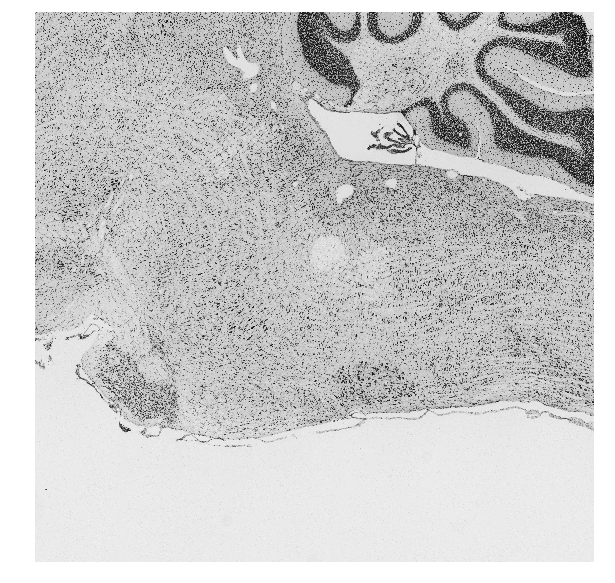

In [10]:
plt.figure(figsize=(10,10));
plt.imshow(img[:10000, :10000], cmap=plt.cm.gray);
plt.axis('off');

# Method 1: Use dictionary learning (iteratively updating dictionary and coding)

In [30]:
dl = DictionaryLearning(n_components=100, alpha=10, max_iter=1, tol=1e-08, fit_algorithm='lars', 
                   transform_algorithm='lasso_cd', transform_n_nonzero_coefs=None, transform_alpha=None, 
                   n_jobs=1, code_init=None, dict_init=None, verbose=False, split_sign=False, random_state=None)

dl.fit(data)

DictionaryLearning(alpha=10, code_init=None, dict_init=None,
          fit_algorithm='lars', max_iter=1, n_components=100, n_jobs=1,
          random_state=None, split_sign=False, tol=1e-08,
          transform_algorithm='lasso_cd', transform_alpha=None,
          transform_n_nonzero_coefs=None, verbose=False)

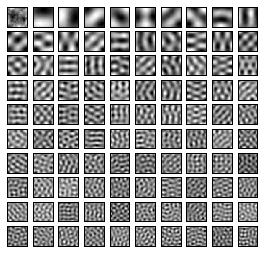

In [31]:
# Plot the results
plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(dl.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())

plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

In [ ]:
X = dl.transform(data)
reconstructed_all = np.dot(X, dl.components_)

In [54]:
L1_diff = np.sum(np.abs(reconstructed_all - data)) / (len(data)*patch_size[0]*patch_size[1])
print 'mean L1 difference per pixel = ', L1_diff

mean L1 difference per pixel =  4.68067801823


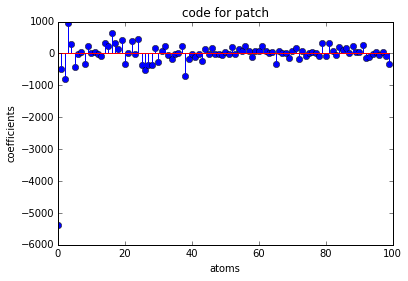

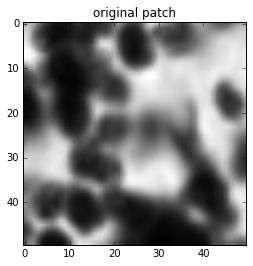

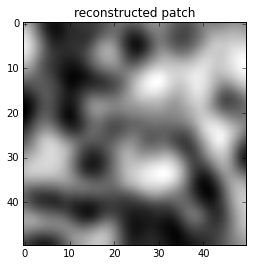

In [53]:
x = dl.transform(data[502])
reconstructed = np.ravel(np.dot(x, dl.components_))

plt.figure();
plt.stem(x);
plt.title('code for patch');
plt.ylabel('coefficients');
plt.xlabel('atoms');
plt.show();

plt.figure();
plt.imshow(data[502].reshape(patch_size), cmap=plt.cm.gray)
plt.title('original patch');
plt.show();

plt.figure();
plt.imshow(reconstructed.reshape(patch_size), cmap=plt.cm.gray)
plt.title('reconstructed patch');
plt.show();

# Method 2: Use KMeans to learn dictionary, then do sparse coding

In [11]:
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=100, random_state=rng, verbose=True)

kmeans.fit(data)

In [13]:
valid = np.where(np.bincount(kmeans.labels_))[0]
valid_centers = kmeans.cluster_centers_[valid]

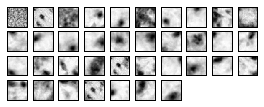

In [14]:
# Plot the results
plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(valid_centers):
    plt.subplot(10, 10, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())

plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

In [25]:
D = np.array([valid_centers[i] for i in range(len(valid_centers))])

In [55]:
X = coder.transform(data)
reconstructed_all = np.dot(X, D)

In [56]:
L1_diff = np.sum(np.abs(reconstructed_all - data)) / (len(data)*patch_size[0]*patch_size[1])
print 'mean L1 difference per pixel = ', L1_diff

mean L1 difference per pixel =  10.5913332663


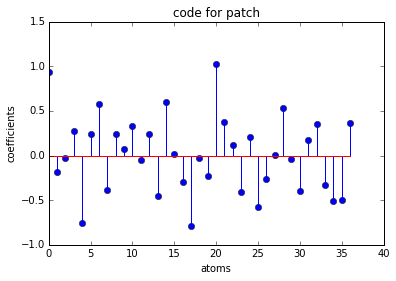

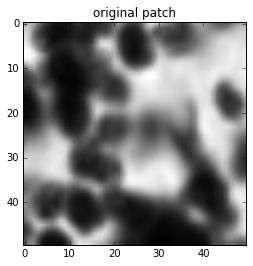

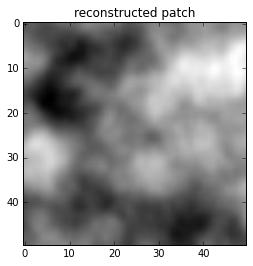

In [35]:
coder = SparseCoder(dictionary=D, transform_n_nonzero_coefs=2,
                    transform_alpha=100, transform_algorithm='lasso_cd')

x = coder.transform(data[502])
reconstructed = np.ravel(np.dot(x, D))

plt.figure();
plt.stem(x);
plt.title('code for patch');
plt.ylabel('coefficients');
plt.xlabel('atoms');
plt.show();

plt.figure();
plt.imshow(data[502].reshape(patch_size), cmap=plt.cm.gray)
plt.title('original patch');
plt.show();

plt.figure();
plt.imshow(reconstructed.reshape(patch_size), cmap=plt.cm.gray)
plt.title('reconstructed patch');
plt.show();